在计量经济学中，常使用蒙特卡罗法来确定统计量的小样本性质。我们知道，许多统计量的精确分布没有解析解。解决方法之一是，使用大样本理论，用渐近分布来近似真实分布。然而，使用大样本理论的代价是要求样本容量较大，而现实中的样本容量可能不够。另外，有时统计量的分布即使在大样本的假设下，也推导不出来。此时，蒙特卡罗法的价值就更加凸显，比如单位根检验。


蒙特卡罗法的基本步骤如下：

第一步，给定参数 $\beta$ 的具体取值，以及解释变量 $x$ 与扰动项 $\varepsilon$ 的概率分布。<br>
第二步，从 $x$ 与 $\varepsilon$ 的分布中随机抽样，得到 $\{x_1, x_2, \cdots, x_n\}$ 与 $\{\varepsilon_1, \varepsilon_2, \cdots, \varepsilon_n\}$。<br>
第三步，根据方程“$y_i = x'_i \beta + \varepsilon_i$”计算$\{y_1, y_2, \cdots, y_n\}$。<br>
第四步，对这个样本进行OLS估计，计算检验统计量$W$，并与$\chi^2(m)$的5\%临界值比较，确定是否拒绝原假设“$H_0: R\beta = r$”。<br>
第五步，大量重复第二至第四步，得到$M$个随机样本（比如，$M=1000$），进行$M$次检验，其中拒绝原假设的比例就是真实的显著性水平。

模拟中心极限定理

In [5]:
import os
import stata_setup
from tensorflow.python.ops.numpy_ops import argmin

## 设置pystata目录
stata_setup.config(os.getenv("STATA_SYSDIR"), 'mp')

In [10]:
from pystata import stata

stata.run(
    """
    // 删除用户自定义的程序
    program drop onesample

    // 程序命令：定义名为onesample的程序，并以r()形式存储结果
    program onesample, rclass
    // 删除内存中已有的数据
    drop _all
    // 设置随机抽样的样本容量为30
    set obs 30
    // 生成在(0,1)区间上均匀分布的1个随机样本
    gen x = runiform()
    // 使用"sum"命令计算样本均值
    sum x
    // 将样本均值存储为r(mean_sample)
    return scalar mean_sample = r(mean)
    // 结束onesample程序
    end

    // 模拟命令：进行10,000次重复模拟，每次调用onesample程序，种子设为101，结果存储在xbar中
    simulate xbar=r(mean_sample), seed(101) reps(10000): onesample
    """
)


. 
.     // 删除用户自定义的程序
.     program drop onesample

. 
.     // 程序命令：定义名为onesample的程序，并以r()形式存储结果
.     program onesample, rclass
  1.     // 删除内存中已有的数据
.     drop _all
  2.     // 设置随机抽样的样本容量为30
.     set obs 30
  3.     // 生成在(0,1)区间上均匀分布的1个随机样本
.     gen x = runiform()
  4.     // 使用"sum"命令计算样本均值
.     sum x
  5.     // 将样本均值存储为r(mean_sample)
.     return scalar mean_sample = r(mean)
  6.     // 结束onesample程序
.     end

. 
.     // 模拟命令：进行10,000次重复模拟，每次调用onesample程序，种子设为101，结
> 果存储在xbar中
.     simulate xbar=r(mean_sample), seed(101) reps(10000): onesample

      Command: onesample
         xbar: r(mean_sample)

Simulations (10,000)
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
..................................................    50
..................................................   100
..................................................   150
..................................................   200
..................................................   250
..................

(bin=40, start=.30437654, width=.00956531)


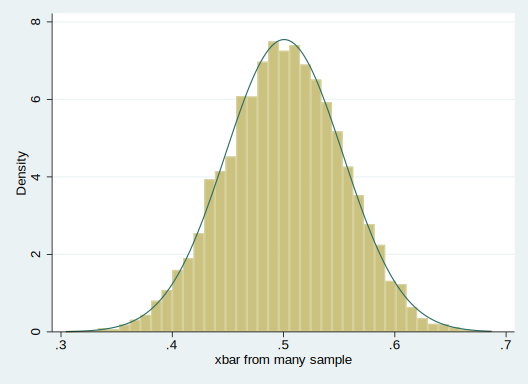

In [11]:
%stata hist xbar, normal xtitle("xbar from many sample")

从上图的结果来看，$\bar{x}_{30}$（xbar）的直方图与相应的正态分布十分接近，从而验证了中心极限定理适用于均匀分布的随机变量。从这个例子也可以看出蒙特卡罗法的一个局限，即仅仅这个蒙特卡罗模拟本身并不能说明中心极限定理也适用于具有其他分布的随机变量。


服从卡方分布的扰动项

考虑下面的数据生成过程(DGP)：
\begin{equation}
    y = \alpha + \beta x + \varepsilon, \quad \varepsilon \sim \chi^2(1) - 1, \quad x \sim \chi^2(1)
\end{equation}
其中，$\alpha=1$，$\beta=2$，样本容量为$n=30$。解释变量$x$服从$\chi^2(1)$分布，而扰动项$\varepsilon$为经过位移后的$\chi^2(1)$分布（以保证其期望为零），而且$x$与$\varepsilon$相互独立。由于小样本理论要求扰动项服从正态分布，这个模型显然不满足小样本理论的假定，但符合大样本理论的要求。

In [20]:
stata.run(
    """
    program chi2data, rclass
    drop _all
    set obs 30
    gen double x = rchi2(1)
    gen y = 1 + 2 * x + rchi2(1) - 1
    reg y x
    return scalar t2 = (_b[x] - 2) / _se[x]
    return scalar r2 = abs(return(t2)) > invttail(28, 0.025)
    end
    simulate reject = r(r2), reps(1000) seed(101): chi2data

    program drop chi2data

    """
)


. 
.     program chi2data,rclass
  1.     drop _all
  2.     set obs 30
  3.     gen double x = rchi2(1)
  4.     gen y = 1 + 2 * x + rchi2(1) - 1
  5.     reg y x
  6.     return scalar t2 = (_b[x] - 2) / _se[x]
  7.     return scalar r2 = abs(return(t2)) > invttail(28, 0.025)
  8.     end

.     simulate reject = r(r2), reps(1000) seed(101): chi2data

      Command: chi2data
       reject: r(r2)

Simulations (1,000)
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
..................................................    50
..................................................   100
..................................................   150
..................................................   200
..................................................   250
..................................................   300
..................................................   350
..................................................   400
..................................................   450
............

In [21]:
%stata mean reject


Mean estimation                          Number of obs = 1,000

--------------------------------------------------------------
             |       Mean   Std. err.     [95% conf. interval]
-------------+------------------------------------------------
      reject |       .035   .0058145      .0235899    .0464101
--------------------------------------------------------------


在上述程序中，“invttail(28,0.025)”给出了$t(28)$分布所对应的显著性水平为5\%的双边检验的临界值。该模拟结果显示（参见上表），拒绝原假设的比例为4.6\%，比较接近于5\%的名义显著性水平。


蒙特卡罗积分

In [22]:
stata.run(
    """
    clear all
    set obs 100
    set seed 10101
    gen double y = rnormal(0,1)
    gen double gy = exp(-exp(y))
    sum gy
    """
)


. 
.     clear all

.     set obs 100
Number of observations (_N) was 0, now 100.

.     set seed 10101

.     gen double y = rnormal(0,1)

.     gen double gy = exp(-exp(y))

.     sum gy

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
          gy |        100    .3656617    .2711514   6.06e-08   .9588919

.     
. 


上表显示，当 S=100 时，表达式 (19.6) 的蒙特卡罗估计值为 0.3679463。但我们并不知道 S=100 是否能达到足够的精确度。为此，令 S=1000，重复上述命令。

In [29]:
stata.run(
    """
    clear all
    set obs 100000
    set seed 10101
    gen double y = rnormal(0,1)
    gen double gy = exp(-exp(y))
    sum gy
    """
)


. 
.     clear all

.     set obs 1000000
Number of observations (_N) was 0, now 1,000,000.

.     set seed 10101

.     gen double y = rnormal(0,1)

.     gen double gy = exp(-exp(y))

.     sum gy

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
          gy |  1,000,000    .3815571    .2655436   7.11e-70    .992853

.     
. 
